In [2]:
import os
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
module_path = os.path.abspath(os.path.join('../transfermarket/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from transfermarket import leagues, players, teams

In [3]:
prem_clubs_23 = leagues.get_prem_club_list(season="2023")
prem_clubs_23

{'Manchester City': '/manchester-city/startseite/verein/281/saison_id/2022',
 'Liverpool FC': '/fc-liverpool/startseite/verein/31/saison_id/2022',
 'Chelsea FC': '/fc-chelsea/startseite/verein/631/saison_id/2022',
 'Arsenal FC': '/fc-arsenal/startseite/verein/11/saison_id/2022',
 'Manchester United': '/manchester-united/startseite/verein/985/saison_id/2022',
 'Tottenham Hotspur': '/tottenham-hotspur/startseite/verein/148/saison_id/2022',
 'Aston Villa': '/aston-villa/startseite/verein/405/saison_id/2022',
 'West Ham United': '/west-ham-united/startseite/verein/379/saison_id/2022',
 'Newcastle United': '/newcastle-united/startseite/verein/762/saison_id/2022',
 'Leicester City': '/leicester-city/startseite/verein/1003/saison_id/2022',
 'Everton FC': '/fc-everton/startseite/verein/29/saison_id/2022',
 'Wolverhampton Wanderers': '/wolverhampton-wanderers/startseite/verein/543/saison_id/2022',
 'Brighton & Hove Albion': '/brighton-amp-hove-albion/startseite/verein/1237/saison_id/2022',
 'Br

In [4]:
# prem_23_avail = {}
# for team, team_url in list(prem_clubs_23.items())[14:]:
#     print(f"grabbing data for {team}")

#     team_avail_23 = []
#     try:
#         for player,url in teams.get_players(team_url).items():
#             avail_df = players.get_player_availability("https://www.transfermarkt.com" + url,"2022")
#             if avail_df is not None:
#                 team_avail_23.append(avail_df)

#         team_avail_23 = pd.concat([df.loc[:,~df.columns.duplicated()] for df in team_avail_23])
#         team_fix = teams.get_team_fixtures(team_url, "2022")

#         team_fix_avail = team_avail_23.T.join(team_fix, how="right")

#         num_players = len(team_avail_23)
#         team_fix_avail = team_fix_avail.iloc[:, :num_players].T
#         prem_23_avail[team] = team_fix_avail
#     except Exception as e:
#         print(e)
#         print(f"failed for {team}")
#         continue

In [5]:
import pickle

In [6]:
# with open("prem_23_avail", "xb") as f:
#     pickle.dump(prem_23_avail, f)

In [7]:
with open("prem_23_avail", "rb") as f:
    prem_23_avail = pickle.load(f)
prem_injury_counts = {}
for team, df in prem_23_avail.items():
    injury_sum_df = pd.DataFrame((df==0).sum(axis=0))
    injury_sum_df = injury_sum_df.rename({0:team}, axis=1)

    prem_injury_counts[team] = injury_sum_df
from datetime import datetime

all_injury_dfs = [df for _, df in prem_injury_counts.items()]
all_injuries = pd.concat(all_injury_dfs, axis=1)
all_injuries = all_injuries[all_injuries.index>=datetime(2022,8,5)].sort_index().fillna(method='bfill')
all_injuries = all_injuries.reindex(pd.date_range('2022-08-05', '2023-01-05'), method='bfill')
all_injuries_unstacked = all_injuries.unstack().reset_index().rename({'level_0':'team','level_1':'date', 0:'#injured players'}, axis=1)
all_injuries_unstacked.head()

In [12]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['font.family'] = 'JetBrains Mono'

In [13]:
all_injuries

,Manchester City,Liverpool FC,Chelsea FC,Arsenal FC,Manchester United,Tottenham Hotspur,Aston Villa,West Ham United,Newcastle United,Leicester City,Everton FC,Wolverhampton Wanderers,Brighton & Hove Albion,Brentford FC,Southampton FC,Crystal Palace,Leeds United,Nottingham Forest,Fulham FC,AFC Bournemouth
2022-08-05,1.0,5.0,0.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,0.0
2022-08-06,1.0,5.0,0.0,1.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,0.0
2022-08-07,1.0,5.0,1.0,1.0,4.0,2.0,0.0,1.0,3.0,0.0,3.0,3.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0
2022-08-08,1.0,5.0,1.0,1.0,4.0,2.0,0.0,1.0,3.0,0.0,3.0,3.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0
2022-08-09,1.0,5.0,1.0,1.0,4.0,2.0,0.0,1.0,3.0,0.0,3.0,3.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,NaN,3.0,7.0,1.0,0.0,2.0,1.0,NaN,1.0,4.0,1.0,NaN,1.0,0.0,NaN,NaN,NaN,2.0,1.0,1.0
2023-01-02,NaN,3.0,NaN,1.0,0.0,NaN,NaN,NaN,1.0,4.0,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0
2023-01-03,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0,4.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2023-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/ismail/projects/football-data-viz/pl-23-injuries/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


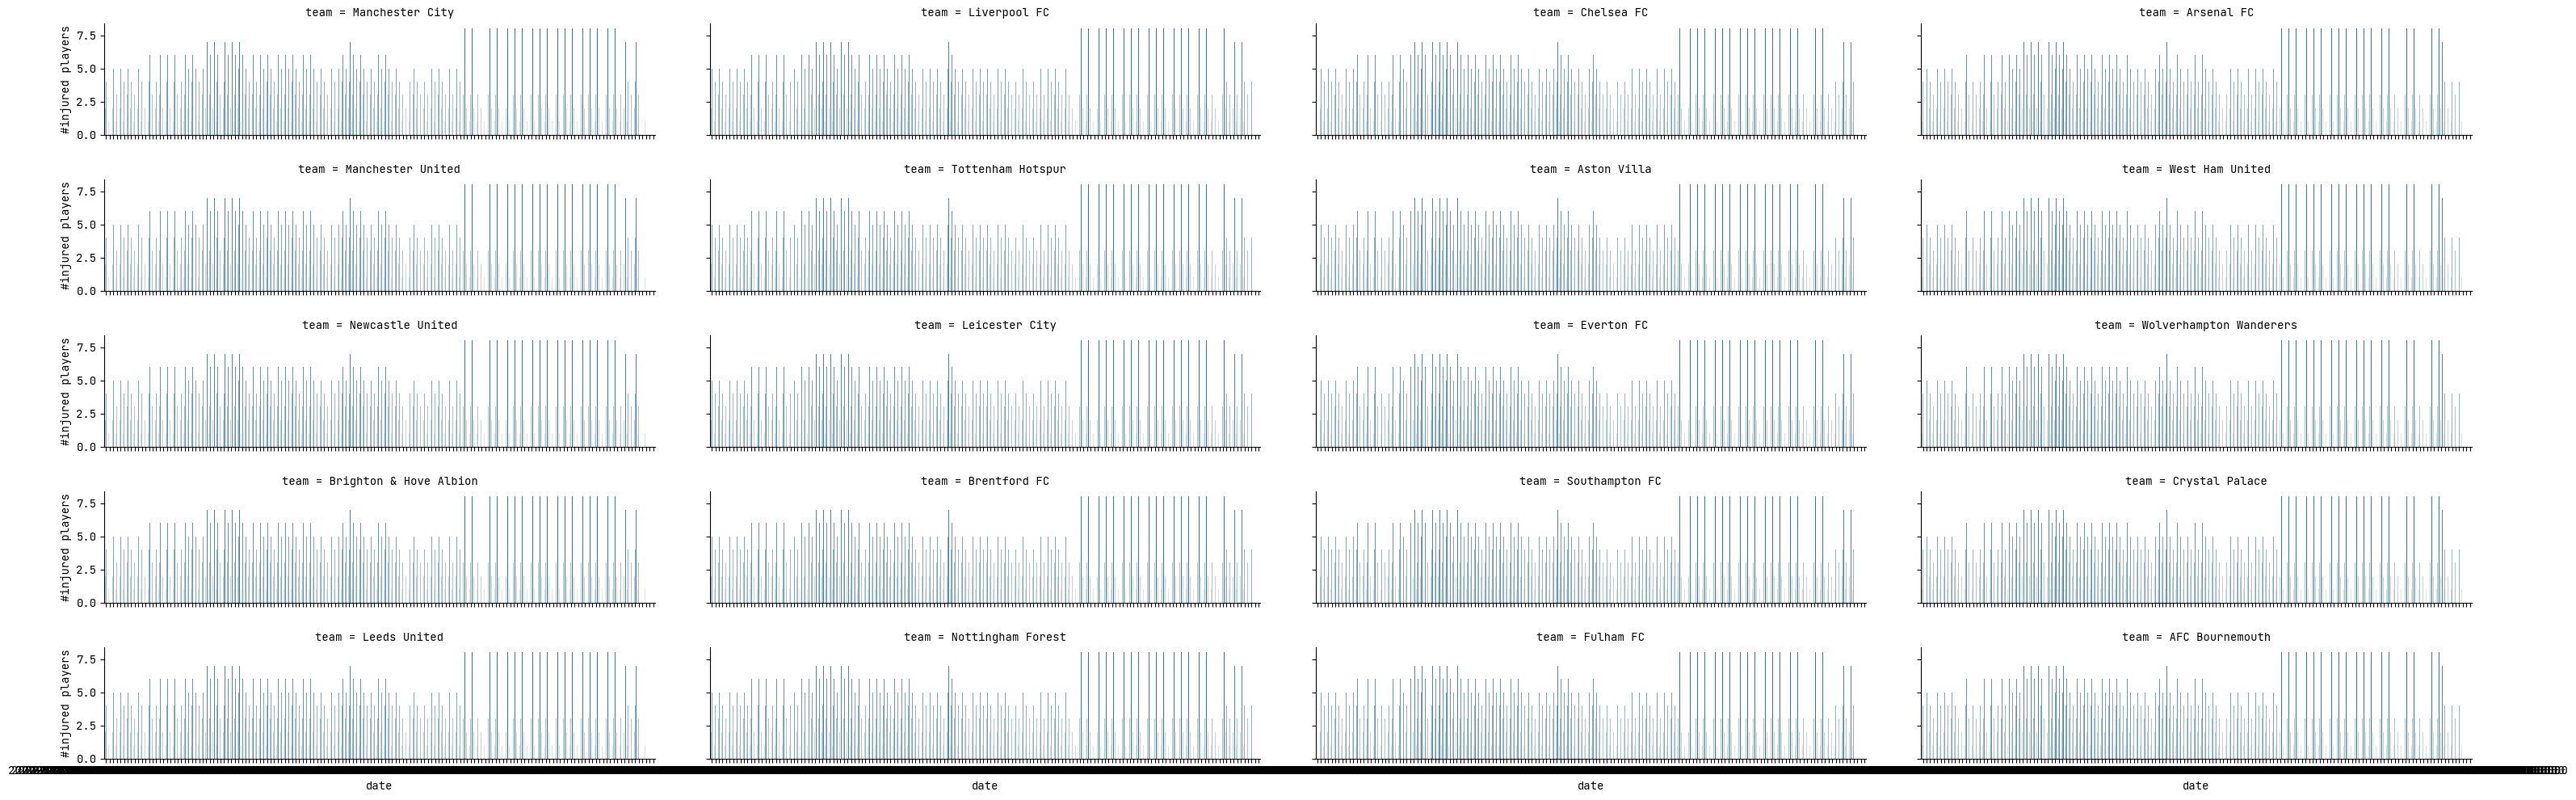

In [14]:
g=sns.FacetGrid(all_injuries_unstacked, col='team', sharey=True, height=2, aspect=4, col_wrap= 4,)
g.map(sns.barplot,data=all_injuries_unstacked, x= 'date',y='#injured players', errorbar=None, hue='#injured players')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.1)

In [198]:
with open("prem_23_avail", "rb") as f:
    prem_23_avail = pickle.load(f)
prem_injury_counts = {}
for team, df in prem_23_avail.items():
    injury_sum_df = pd.DataFrame((df==0).sum(axis=0))
    injury_sum_df = injury_sum_df.rename({0:team}, axis=1)

    prem_injury_counts[team] = injury_sum_df
from datetime import datetime

all_injury_dfs = [df for _, df in prem_injury_counts.items()]
all_injuries = pd.concat(all_injury_dfs, axis=1)
all_injuries = all_injuries[all_injuries.index>=datetime(2022,8,5)].sort_index().fillna(method='bfill')
all_injuries = all_injuries.reindex(pd.date_range('2022-08-05', '2023-01-05'), method='bfill')
all_injuries_unstacked = all_injuries.unstack().reset_index().rename({'level_0':'team','level_1':'date', 0:'#injured players'}, axis=1)
all_injuries_unstacked.head()
all_injuries = all_injuries.fillna(method='bfill').fillna(method='ffill')
prem_standings = pd.read_html("https://www.bbc.co.uk/sport/football/tables")[0]
prem_standings = prem_standings.iloc[:-1, [0,2]].rename({'Unnamed: 0':'prem_position'}, axis=1).set_index('Team')
from fuzzywuzzy import process
# https://stackoverflow.com/a/56315491
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1
prem_standings = prem_standings.reset_index()
all_injuries = all_injuries.T
merged_standings = fuzzy_merge(all_injuries.reset_index(), prem_standings, key1='index', key2='Team', threshold=65, limit=1)
merged_standings.loc[merged_standings['index']=="Manchester United", 'matches'] = 'Man Utd'
merged_standings = merged_standings.merge(prem_standings, how='left', left_on='matches', right_on='Team')
injury_heatmap_data = merged_standings.rename({'matches':'team'}, axis=1).set_index('team').drop('index', axis=1)
injury_heatmap_data.head()

,2022-08-05 00:00:00,2022-08-06 00:00:00,2022-08-07 00:00:00,2022-08-08 00:00:00,2022-08-09 00:00:00,2022-08-10 00:00:00,2022-08-11 00:00:00,2022-08-12 00:00:00,2022-08-13 00:00:00,2022-08-14 00:00:00,...,2022-12-29 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00,2023-01-01 00:00:00,2023-01-02 00:00:00,2023-01-03 00:00:00,2023-01-04 00:00:00,2023-01-05 00:00:00,Team,prem_position
team,,,,,,,,,,,,,,,,,,,,,
Man City,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Man City,2
Liverpool,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,Liverpool,6
Chelsea,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,Chelsea,10
Arsenal,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Arsenal,1
Man Utd,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Man Utd,4


In [199]:
injury_heatmap_data['prem_position'] = pd.to_numeric(injury_heatmap_data['prem_position'])
injury_heatmap_data.sort_values('prem_position', inplace=True, ascending=True)
injury_heatmap_data.drop(['Team', 'prem_position'], axis=1, inplace=True)
injury_heatmap_data.columns = [col.strftime("%b") for col in injury_heatmap_data.columns]

8.0

/tmp/ipykernel_6869/3821863324.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(unique_months)


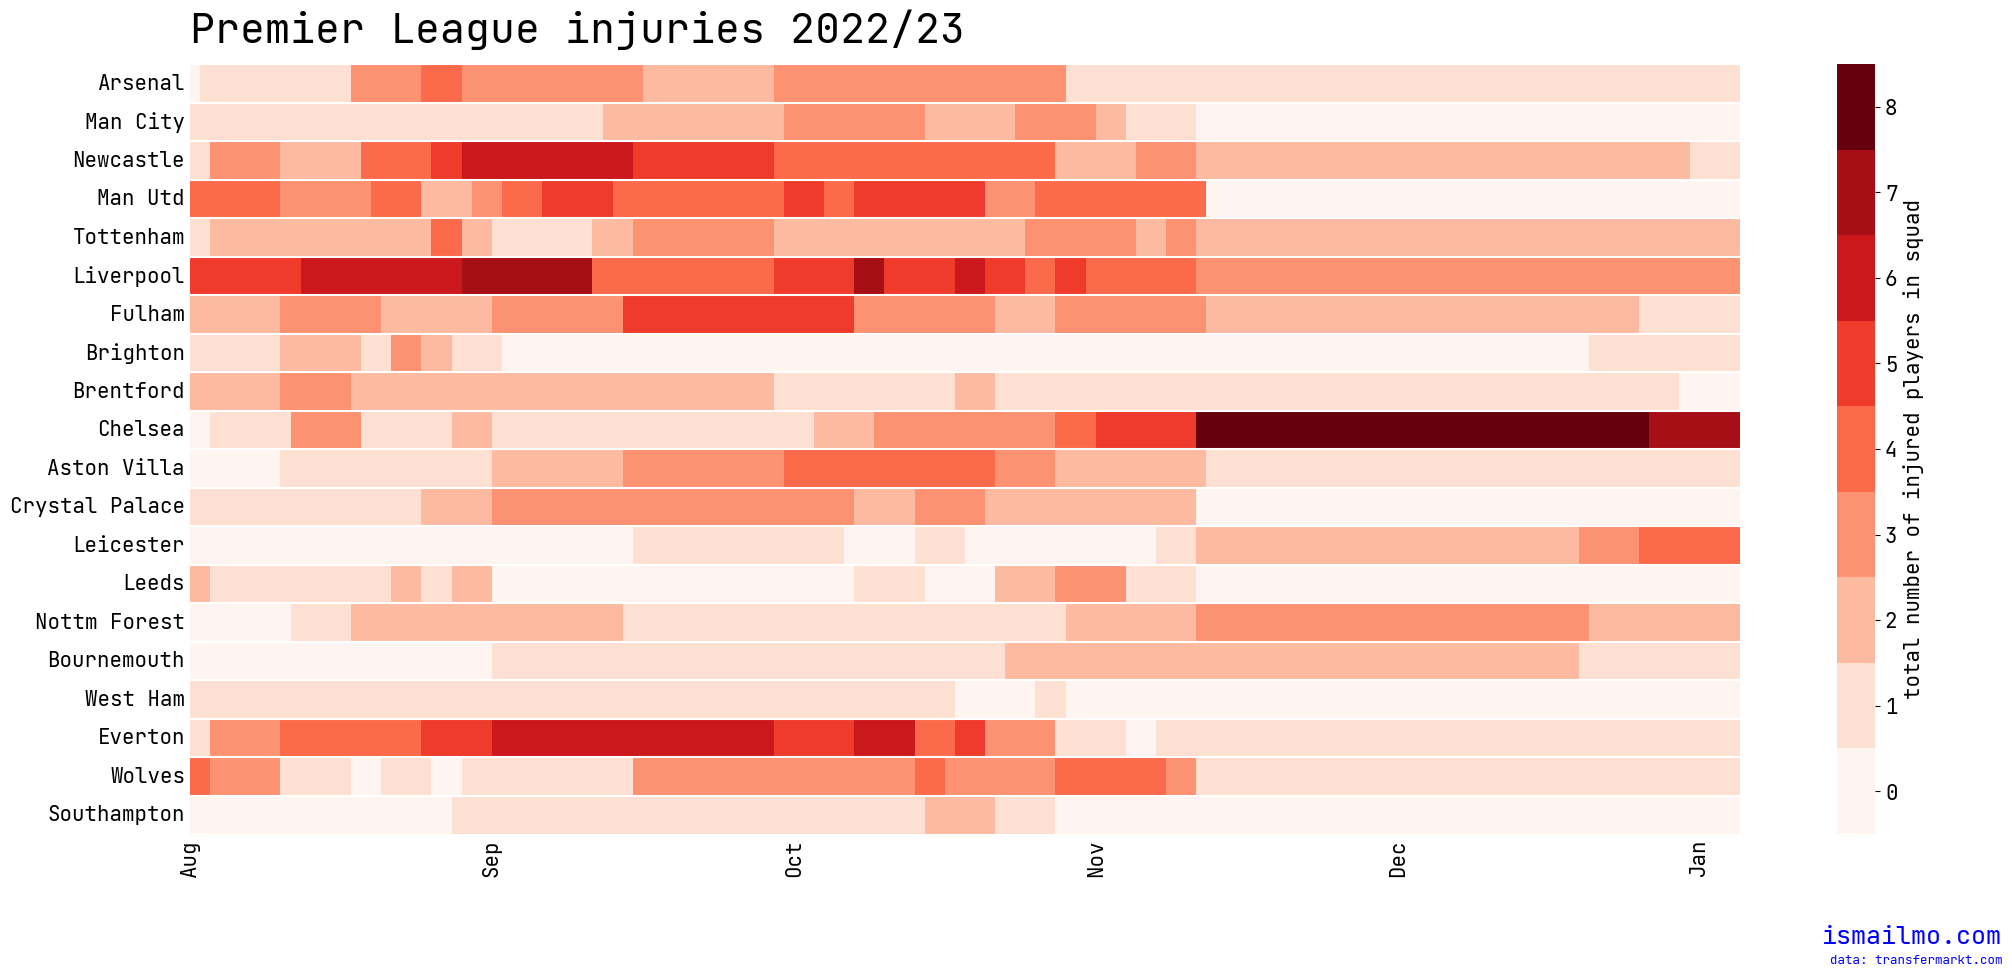

In [278]:
import matplotlib.ticker as t
matplotlib.rcParams['font.size'] = 15
color_scheme = ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#a50f15','#67000d']

fig, ax = plt.subplots(figsize=(25,10))
plot = sns.heatmap(injury_heatmap_data, ax=ax, cmap=color_scheme, cbar_kws={'label': 'total number of injured players in squad'})

num_levels = int(injury_heatmap_data.max(axis=1).max()) + 1
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels(list(range(num_levels)))

ax.tick_params(length=0)
ax.set_title("Premier League injuries 2022/23", loc="left", pad=15, fontdict={'size':30})
ax.set_ylabel("")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.hlines(range(len(injury_heatmap_data)), *ax.get_xlim(), colors=['white'])
ax.xaxis.set_major_locator(t.MaxNLocator(6))

unique_months = sorted(set(injury_heatmap_data.columns), key=[*injury_heatmap_data.columns].index)
ax.set_xticklabels(unique_months)

_ = plt.gcf().text(0.85, -0.00, "ismailmo.com", fontsize=18, fontdict={'color':  'blue'}, ha="right")
_ = plt.gcf().text(0.85, -0.02, "data: transfermarkt.com", fontsize=9, fontdict={'color':  'blue'}, ha="right")